- By: Alex Kwon
- Email: alex.kwon [at] hudsonthames [dot] org
- Reference 1: [Online Portfolio Selection](https://books.google.com/books/about/Online_Portfolio_Selection.html?id=R2fdCgAAQBAJ) by Li and Hoi
- Reference 2: [On-Line Portfolio Selection Using Multiplicative Updates](http://web.cs.iastate.edu/~honavar/portfolio-selection.pdf) by Helmbold, Schapire, Singer, and Wurmuth

# Online Portfolio Selection - Momentum - Exponential Gradient

## Abstract

Momentum strategies have been a popular quantitative strategy in recent decades as the simple but powerful trend following allows investors to exponentially increase their returns. Broadly speaking, there are two types of momentum with one following the best performing assets in the last period and the other following the BCRP's until the last period.

In this notebook, we will dive into Exponential Gradient, a momentum strategy that focuses on the best performing asset of the last time period. The portfolio shifts its weights to the best performing asset of the last period with an adjustment of $\eta$, the learning rate. A higher value of $\eta$ indicates the aggressiveness of the strategy to match the best performing assets. A lower value of $\eta$ indicates the passivness of the strategy to match the best performing assets.

In traditional papers, $\eta$ of 0.05 was proved to be the most profitable strategy in the long run, and through this analysis, we find out that it is true for the datasets previous researchers have used. However, in the new data that I explored, I found that with the inclusion of a dominant asset, a higher eta value is necessary to follow the best stock. From the $\eta$ values explored, a value around 20 produced the best results that would follow the best performing asset and would not deviate too much with market noise.

The package and module behind this implementation of OLPS is currently in the works and will be published on MlFinLab soon.

**1. Exponential Gradient**
   - Multiplicative Update
   - Gradient Projection
   - Expectation Maximization
    
**2. Data Exploration**
   - NYSE: 1962-1984
   - DJIA: 2001-2003
   - TSE: 1994-1998
   - SP500: 1998-2003
   - MSCI: 1993-2020
   - US Equity: 2011-2020

# Strategy

Throughout the next couple weeks, we will be releasing notebooks on the following strategies

[**Benchmarks**](https://github.com/hudson-and-thames/research/blob/master/Online%20Portfolio%20Selection/Introduction%20to%20Online%20Portfolio%20Selection.ipynb)
- Buy and Hold
- Best Stock
- Constant Rebalanced Portfolio
- Best Constant Rebalanced Portfolio

**Momentum**
- Exponential Gradient
- Follow the Leader
- Follow the Regularized Leader

**Mean Reversion**
- Anti-Correlation
- Passive Aggressive Mean Reversion
- Online Moving Average Reversion
- Robust Median Mean Reversion

**Pattern Matching**
- Nonparametric Histogram/Kernel-Based/Nearest Neighbor Log-Optimal
- Correlation Driven Nonparametric Learning
- Nonparametric Kernel-Based Semi-Log-Optimal/Markowitz/GV

**Meta Algorithm**
- Aggregating Algorithm
- Fast Universalization Algorithm
- Online Gradient Updates
- Online Newton Updates
- Follow the Leading History

**Universal Portfolio**
- Universal Portfolio
- CORN-U
- CORN-K
- SCORN-K
- FCORN-K

In [97]:
import pandas as pd
import numpy as np
import pickle
import optuna
import matplotlib.pyplot as plt
from mlfinlab.online_portfolio_selection import *
plt.rcParams["figure.figsize"] = (20, 8)

## Import Data

More information on these datasets is available [here].

In [153]:
msci = pd.read_csv('data/MSCI.csv', parse_dates=True, index_col='Date').dropna()[1:]
us_equity = pd.read_csv('data/US_Equity.csv', parse_dates=True, index_col='Date')
djia = pd.read_csv('data/DJIA.csv', parse_dates=True, index_col='Date').cumprod()
nyse = pd.read_csv('data/NYSE.csv', parse_dates=True, index_col='Date').cumprod()
sp500 = pd.read_csv('data/SP500.csv', parse_dates=True, index_col='Date').cumprod()
tse = pd.read_csv('data/TSE.csv', parse_dates=True, index_col='Date').cumprod()

## 1. Exponential Gradient

Exponential Gradient strategies focus on the following optimization problem that tracks the best performing stock with a learning rate, $\eta$, but also regularizes the new portfolio weight to prevent drastic changes from the previous portfolio.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \: \eta \log b \cdot x_t - R(b,b_t)$

### 1.1 Multiplicative Update 

Helmbold proposed a regularization term that adopts relative entropy.

$R(b,b_t) = \overset{m}{\underset{i=1}{\sum}}b_i \log \frac{b_i}{b_{t,i}}$

    
Using log's first order taylor expansion of $b_i$

$\log b \cdot x_t \approx \log(b_t \cdot x_t) + \frac{x_t}{b_t \cdot x_t}(b-b_t)$

Multiplicative update algorithm can be stated as the following
    
$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right)$

If we adopt relative entropy as the regularization factor, we can use log's first order taylor expansion to create an update rule to be the following multiplicative one.

$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right) / Z$, where $Z$ is a normalization term to sum the weights to 1

### 1.2 Gradient Projection

Instead of relative entropy, gradient projection adopts an L2-regularization term for the optimization equation.

$R(b,b_t) = \frac{1}{2}\overset{m}{\underset{i=1}{\sum}}(b_i - b_{t,i})^2$

This regularization term can be transcribed to the following update rule

$b_{t+1} = b_t + \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - \frac{1}{m} \sum_{j=1}^{m} \frac{x_t}{b_t \cdot x_t} \right)$

### 1.3 Expectation Maximization

Expectation Maximization uses a $\chi^2$ regularization term

$R(b-b_t)=\frac{1}{2}\overset{m}{\underset{i=1}{\sum}}\frac{(b_i - b_{t,i})^2}{b_{t,i}}$

Then, the corresponding update rule becomes

$b_{t+1} = b_t \cdot \left( \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - 1 \right) + 1 \right)$

Each of these update rules can be called using the **ExponentialGradient()** with different update rules with the default being multiplciative updates.

Learning rates can also be adjusted by setting **eta**, and if no values are stated default will be 0.05

- Multiplicative Update: ExponentialGradient('MU', eta=0.05)
- Gradient Projection: ExponentialGradient('GP', eta=0.1)
- Expectation Maximization: ExponentialGradient('EM', eta=1)

## 2.1 NYSE: 1961-1984

We'll first look at the dataset covered by Thomas Cover's original Universal Portfolio.

Most of the stocks increased during this period with Philips Morris increasing by more than 53 times.

In [111]:
beststock = BestStock();beststock.allocate(nyse);display(beststock.all_weights.iloc[-1].to_frame().T)
display(nyse.iloc[-1].to_frame().T)

,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
1984-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
1984-12-31,13.103622,4.347081,16.100538,16.902053,13.357385,52.020292,8.760266,3.065435,13.707717,14.15607,...,14.430813,5.979156,15.214815,54.140364,6.975924,16.204888,43.128665,4.24545,6.537269,5.388037


I'll be dividing the parameters into two sets. The first will be a "small" set that looks at parameter values between 0 and 1. The second will be a "large" set that looks at parameter values between 1 and 100. I used the optuna package to find the ideal hyperparameter for Expectation Gradient and pickled the objects.

In [40]:
data = 'NYSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    nyse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    nyse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    nyse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    nyse_large_eta_optuna = pickle.load(f)

In [86]:
# Eta of [0, 1] for NYSE
optuna.visualization.plot_slice(nyse_small_eta_optuna)

In [45]:
# Eta of [1, 100] for NYSE
optuna.visualization.plot_slice(nyse_large_eta_optuna)

In [91]:
display(nyse_small_eta_optuna.best_params)
display(nyse_small_eta_optuna.best_trial)

{'eta': 0.07364226809952339}

FrozenTrial(number=397, value=26.706310066442498, datetime_start=datetime.datetime(2020, 4, 28, 11, 8, 4, 65002), datetime_complete=datetime.datetime(2020, 4, 28, 11, 8, 4, 461693), params={'eta': 0.07364226809952339}, distributions={'eta': UniformDistribution(high=1, low=0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=397, state=TrialState.COMPLETE)

Results for this data indicate similar results as Helmbold's findings. $\eta$ of 0.05 was proposed as an ideal parameter, and through our tuning, we found that the best parameter is 0.073.

Text(0.5, 1.0, 'Exponential Gradient on NYSE')

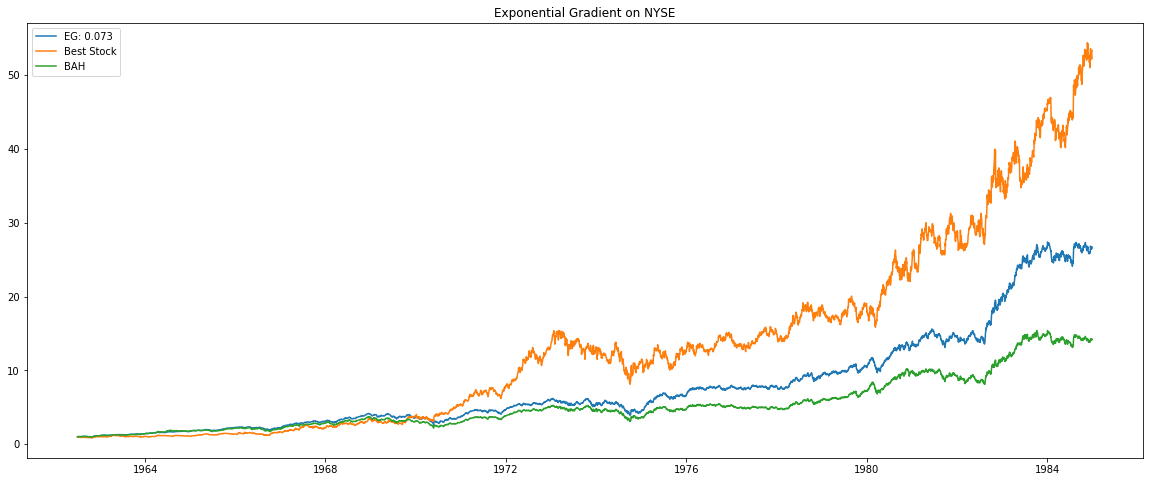

In [102]:
bah = BuyAndHold(); bah.allocate(nyse)
plt.plot(nyse_small_eta_list[397].portfolio_return, label = 'EG: 0.073')
plt.plot(beststock.portfolio_return, label = 'Best Stock');
plt.plot(bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on NYSE')

Comparing our results to other benchmarks, Best Stock increased is the change in Philip Morris. A uniform buy and hold result as a 10-fold increase. Our exponential gradient strategy achieves around 20 times returns.

In [178]:
display(nyse_small_eta_list[397].all_weights.head(2))
display(nyse_small_eta_list[397].all_weights.tail(2))

,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
Date,,,,,,,,,,,,,,,,,,,,,
1962-07-03,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,...,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778
1962-07-05,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,...,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778


,AHP,Alcoa,American Brands,ARCO,Coca Cola,Commercial Metals,Dow Chemical,DuPont,Espey Manufacturing,Exxon,...,Merck,3M,Mobil,Philip Morris,P&G,Pillsbury,Schlumberger,Sears,Sherwin Williams,Texaco
Date,,,,,,,,,,,,,,,,,,,,,
1984-12-28,0.026967,0.025214,0.027317,0.027910,0.027024,0.032716,0.026278,0.024081,0.033563,0.026896,...,0.027143,0.025355,0.027679,0.030062,0.025587,0.027869,0.029860,0.024814,0.026381,0.025393
1984-12-31,0.026944,0.025218,0.027308,0.027918,0.027031,0.032718,0.026260,0.024096,0.033598,0.026904,...,0.027148,0.025341,0.027679,0.030087,0.025574,0.027865,0.029879,0.024791,0.026426,0.025391


The value of eta strongly affects our changes in weights. A low value of eta explored in this data indicate minimal deviation. The results at the end are almost similar to what we would expect from a simple buy and hold strategy.

## 2.2 DJIA: 2001-2003

This DJIA set covers a bear market run with most companies losing value.

In [181]:
djia.tail(4)

,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-09,0.688284,0.541728,1.151276,1.164164,0.680908,0.720671,0.539206,1.149404,0.541880,0.417380,...,0.923864,0.919370,0.979408,0.888432,0.582099,0.498393,0.670706,0.838377,0.988890,0.889917
2003-01-10,0.697461,0.536499,1.158364,1.166458,0.682517,0.713556,0.535059,1.154093,0.541081,0.419518,...,0.918440,0.926556,0.975148,0.883299,0.584353,0.508910,0.671042,0.826648,0.993581,0.916951
2003-01-13,0.699602,0.536289,1.134872,1.176262,0.688953,0.725050,0.538811,1.154897,0.548274,0.426905,...,0.912182,0.924760,0.979408,0.877481,0.589183,0.507742,0.670930,0.823364,0.986421,0.923770
2003-01-14,0.708474,0.537753,1.141353,1.188361,0.686986,0.738916,0.544934,1.157175,0.545876,0.428655,...,0.917814,0.936067,0.978698,0.879706,0.594656,0.519720,0.671042,0.830870,0.987161,0.931076


The best performing stock was P&G for this period with 1.15 times the price for a 2 year range.

In [109]:
djia_beststock = BestStock(); djia_beststock.allocate(djia)
display(djia_beststock.all_weights.iloc[-1].to_frame().T); display(djia.iloc[-1].to_frame().T)

,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
2003-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Alcoa,GE,Johnson&Johnson,Microsoft,American Express,General Motors,JP Morgan Chase,P&G,Boeing,Home Depot,...,DuPont,IBM,Philip Morris,Walmart,Walt Disney,Intel,Merck,ExxonMobil,Eastman Kodak,International Paper
2003-01-14,0.708474,0.537753,1.141353,1.188361,0.686986,0.738916,0.544934,1.157175,0.545876,0.428655,...,0.917814,0.936067,0.978698,0.879706,0.594656,0.51972,0.671042,0.83087,0.987161,0.931076


In [112]:
data = 'DJIA'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    djia_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    djia_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    djia_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    djia_large_eta_optuna = pickle.load(f)

In [113]:
# Eta of [0, 1] for DJIA
optuna.visualization.plot_slice(djia_small_eta_optuna)

In [114]:
# Eta of [1, 100] for DJIA
optuna.visualization.plot_slice(djia_large_eta_optuna)

It's not too surprising that most of our portfolio lost in value in the first place because our current problem formulation does not allow for short selling. Generally, all of the stocks decreased in values as well.

In [116]:
display(djia_small_eta_optuna.best_params); display(djia_small_eta_optuna.best_trial)

{'eta': 1.473309438842684e-06}

FrozenTrial(number=736, value=0.8106059699948273, datetime_start=datetime.datetime(2020, 4, 28, 10, 56, 19, 713619), datetime_complete=datetime.datetime(2020, 4, 28, 10, 56, 19, 820994), params={'eta': 1.473309438842684e-06}, distributions={'eta': UniformDistribution(high=1, low=0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=736, state=TrialState.COMPLETE)

The best parameter for this market was a value close to 0.

Text(0.5, 1.0, 'Exponential Gradient on DJIA')

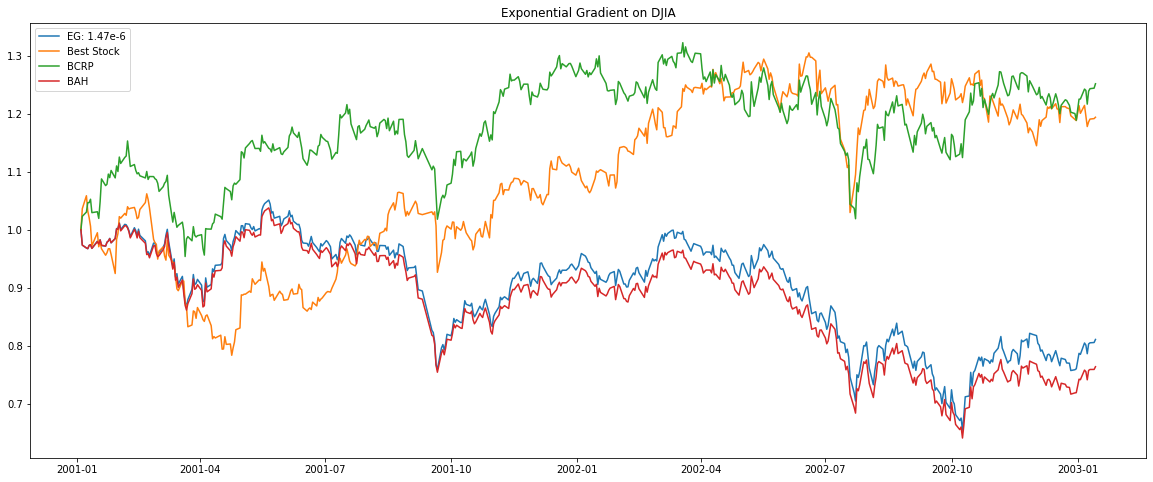

In [121]:
djia_bah = BuyAndHold(); djia_bah.allocate(djia)
djia_bcrp = BestConstantRebalancedPortfolio(); djia_bcrp.allocate(djia)
plt.plot(djia_small_eta_list[736].portfolio_return, label = 'EG: 1.47e-6')
plt.plot(djia_beststock.portfolio_return, label = 'Best Stock')
plt.plot(djia_bcrp.portfolio_return, label = 'BCRP')
plt.plot(djia_bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on DJIA')

For a market with a general downtrend, exponential gradient fails to make a significant effect on our returns. In hindsight, the investors would have allocated their capital on P&G; however, it would have been difficult for investors back then to know that fact.

## TSE: 1994-1998

TSE contains a good mix of companies that both lost and gained in prices over five years.

In [182]:
tse.tail(4)

,Westcoast Energy,Seagram,TVX Gold,Transcanada,Thomson,Talisman,Trilon,Teck,TD Bank,Transalta,...,Cott Corp,Bombardier,Anderson,AUR Resources,Alcan Aluminum,Agnico-Eagle Mines,Alberta Energy,Air Canada,Aber Resources,Barrick Gold Corp
Date,,,,,,,,,,,,,,,,,,,,,
1998-12-28,1.706694,1.729760,0.314291,1.431531,2.488814,0.906779,4.099141,0.495611,2.892180,2.021149,...,0.176781,4.412507,0.900356,0.442871,1.653653,0.366799,1.979006,1.229973,2.092211,0.813941
1998-12-29,1.706694,1.805627,0.310862,1.433421,2.482107,0.887815,4.043995,0.488853,2.969661,2.021149,...,0.164154,4.422568,0.928060,0.451729,1.651682,0.375819,1.967120,1.219974,2.144851,0.829015
1998-12-30,1.706694,1.744934,0.312006,1.423886,2.371417,0.886091,4.043995,0.473084,2.961358,2.007911,...,0.162575,4.312004,0.910745,0.442871,1.645769,0.378825,1.943347,1.219974,2.171168,0.811202
1998-12-31,1.717958,1.767688,0.308578,1.427061,2.408317,0.929191,4.043995,0.504624,2.977971,1.994673,...,0.172045,4.422563,0.962685,0.460586,1.635914,0.378825,1.961168,1.229977,2.263269,0.816685


The best performing stock in hindsight was Gentra with an increase to 6.279 during this period.

In [132]:
tse_beststock = BestStock(); tse_beststock.allocate(tse)
display(tse_beststock.all_weights.iloc[-1,40:60].to_frame().T); display(tse.iloc[-1,40:60].to_frame().T)

,Moore Corp,Macmillan Bloedel,Miramar Mining Corp,Loewen Group,Kinross Gold,Imasco,Imperial Oil,Investors Group,Intl Forest Products,Hudson's Bay,Gentra,Gulf Canada,Franco-Nevada Mining Corp,Fletcher Challenge Canada,First Australia,Extendicare,Euro-Nevada Mining Corp,Canadian 88 Energy Corp,Echo Bay Mines,Domtar
1998-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Moore Corp,Macmillan Bloedel,Miramar Mining Corp,Loewen Group,Kinross Gold,Imasco,Imperial Oil,Investors Group,Intl Forest Products,Hudson's Bay,Gentra,Gulf Canada,Franco-Nevada Mining Corp,Fletcher Challenge Canada,First Australia,Extendicare,Euro-Nevada Mining Corp,Canadian 88 Energy Corp,Echo Bay Mines,Domtar
1998-12-31,0.820145,0.829264,0.226115,0.384622,0.830646,3.938255,2.108617,2.554517,0.167437,0.568515,6.27922,1.066768,1.390163,0.919368,1.32618,1.338604,2.145959,2.605324,0.159136,1.101088


In [133]:
data = 'TSE'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    tse_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    tse_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    tse_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    tse_large_eta_optuna = pickle.load(f)

In [134]:
# Eta of [0, 1] for TSE
optuna.visualization.plot_slice(tse_small_eta_optuna)

In [135]:
# Eta of [1, 100] for TSE
optuna.visualization.plot_slice(tse_large_eta_optuna)

In [136]:
display(tse_small_eta_optuna.best_params); display(tse_small_eta_optuna.best_trial)

{'eta': 2.612195774396946e-06}

FrozenTrial(number=264, value=1.570249601140997, datetime_start=datetime.datetime(2020, 4, 28, 11, 21, 31, 612103), datetime_complete=datetime.datetime(2020, 4, 28, 11, 21, 31, 741656), params={'eta': 2.612195774396946e-06}, distributions={'eta': UniformDistribution(high=1, low=0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=264, state=TrialState.COMPLETE)

Text(0.5, 1.0, 'Exponential Gradient on TSE')

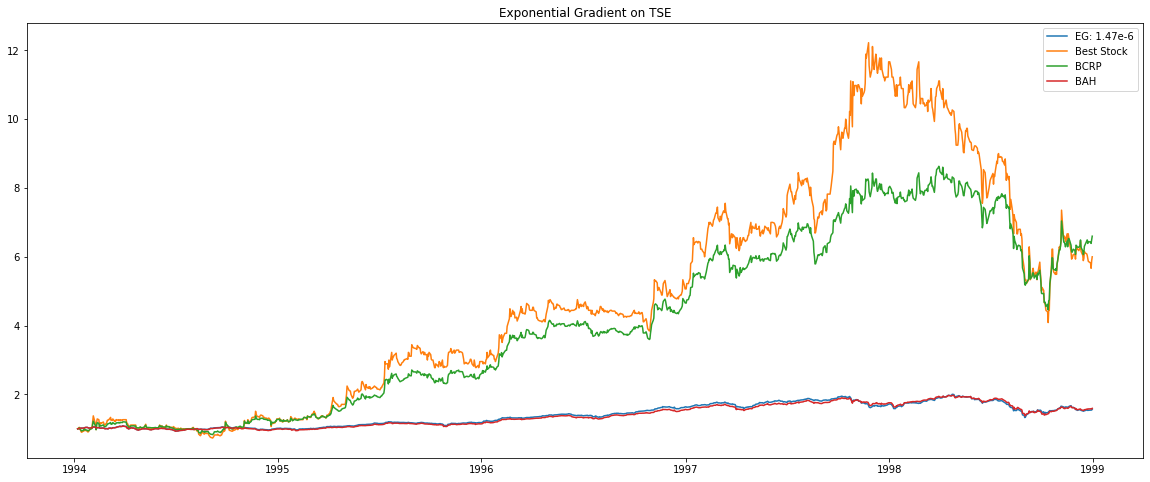

In [137]:
tse_bah = BuyAndHold(); tse_bah.allocate(tse)
tse_bcrp = BestConstantRebalancedPortfolio(); tse_bcrp.allocate(tse)
plt.plot(tse_small_eta_list[264].portfolio_return, label = 'EG: 1.47e-6')
plt.plot(tse_beststock.portfolio_return, label = 'Best Stock')
plt.plot(tse_bcrp.portfolio_return, label = 'BCRP')
plt.plot(tse_bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on TSE')

The returns for Exponential Gradient are dwarfed by the returns posted by Best Stock or BCRP.

## SP500: 1998-2003

In [139]:
sp500.tail()

,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-27,0.934458,1.499945,2.392382,1.028526,1.181567,1.311742,1.603994,1.410271,1.484878,0.961858,...,0.779655,1.224222,3.765837,2.239057,1.126389,0.663219,1.102469,0.793585,1.816223,0.873545
2003-01-28,0.938512,1.489268,2.447239,1.055678,1.189098,1.325573,1.630430,1.430191,1.516878,1.010918,...,0.792850,1.220294,3.825907,2.314626,1.125833,0.649074,1.111921,0.807699,1.827324,0.883989
2003-01-29,0.933647,1.522519,2.443176,1.094143,1.210898,1.328937,1.610757,1.415379,1.520854,1.029315,...,0.828039,1.227103,3.870403,2.363139,1.125278,0.649074,1.125670,0.837851,1.898274,0.888341
2003-01-30,0.914188,1.471575,2.416255,1.074102,1.177603,1.278471,1.584321,1.359959,1.482605,1.012962,...,0.817483,1.213748,3.780669,2.255850,1.075278,0.636530,1.091298,0.823737,1.823463,0.861215
2003-01-31,0.938107,1.447781,2.427938,1.103840,1.203367,1.284079,1.647952,1.382178,1.480712,1.029315,...,0.841895,1.240458,3.779186,2.225996,1.124444,0.652276,1.111921,0.826304,1.860628,0.873835


In [142]:
sp500_beststock = BestStock(); sp500_beststock.allocate(sp500)
display(sp500_beststock.all_weights.iloc[-1].to_frame().T); display(sp500.iloc[-1].to_frame().T)

,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
2003-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,GE,Microsoft,Walmart,ExxonMobil,Pfizer,Citigroup,Johnson & Johnson,AIG,IBM,Merck,...,Verizon,Wells Fargo,Amgen,Dell,PepsiCo,SBC Comms,Fannie Mae,Chevron,Viacom,Eli Lilly
2003-01-31,0.938107,1.447781,2.427938,1.10384,1.203367,1.284079,1.647952,1.382178,1.480712,1.029315,...,0.841895,1.240458,3.779186,2.225996,1.124444,0.652276,1.111921,0.826304,1.860628,0.873835


In [143]:
data = 'SP500'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    sp500_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    sp500_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    sp500_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    sp500_large_eta_optuna = pickle.load(f)

In [144]:
# Eta of [0, 1] for SP500
optuna.visualization.plot_slice(sp500_small_eta_optuna)

In [145]:
# Eta of [1, 100] for SP500
optuna.visualization.plot_slice(sp500_large_eta_optuna)

In [146]:
display(sp500_small_eta_optuna.best_params); display(sp500_small_eta_optuna.best_trial)

{'eta': 2.395215871893962e-06}

FrozenTrial(number=152, value=1.6391662351711398, datetime_start=datetime.datetime(2020, 4, 28, 11, 0, 3, 825189), datetime_complete=datetime.datetime(2020, 4, 28, 11, 0, 3, 959258), params={'eta': 2.395215871893962e-06}, distributions={'eta': UniformDistribution(high=1, low=0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=152, state=TrialState.COMPLETE)

Text(0.5, 1.0, 'Exponential Gradient on SP500')

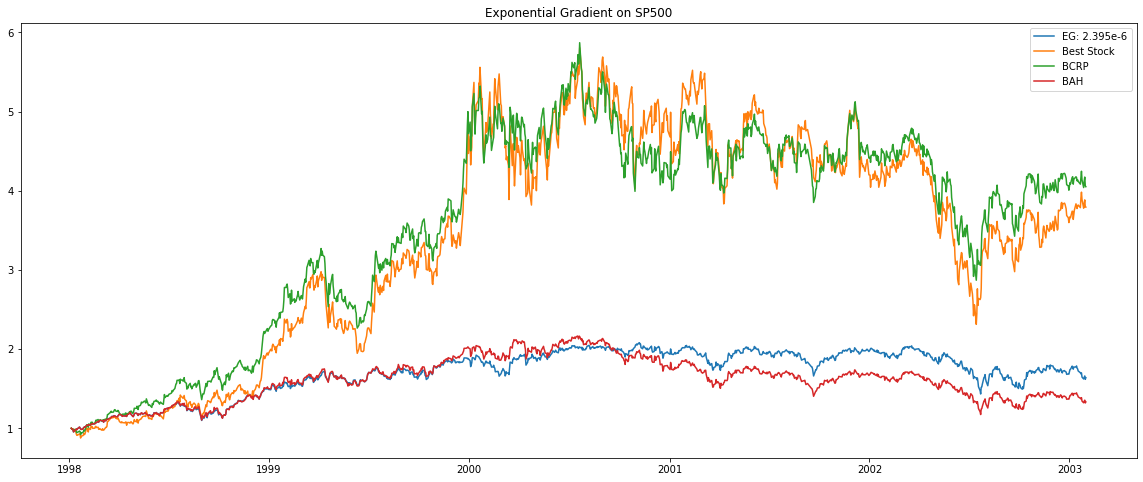

In [192]:
sp500_bah = BuyAndHold(); sp500_bah.allocate(sp500)
sp500_bcrp = BestConstantRebalancedPortfolio(); sp500_bcrp.allocate(sp500)
plt.plot(sp500_small_eta_list[sp500_small_eta_optuna.best_trial.number].portfolio_return, label = 'EG: 2.395e-6')
plt.plot(sp500_beststock.portfolio_return, label = 'Best Stock')
plt.plot(sp500_bcrp.portfolio_return, label = 'BCRP')
plt.plot(sp500_bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on SP500')

SP500 during this time returns are only marginally better for Exponential Gradient compared to a simple Buy and Hold strategy. As seen with the Best Stock and Best Constant Rebalanced Portfolio, no one stock was dominant during this period. With most stocks underperforming.

## MSCI: 1998-2003

In [155]:
msci.tail()

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,618.092773,717.927581,1062.628658,1403.422266,10324.841999,432.592071,1498.223970,1645.032809,10511.885766,157.701903,...,2929.045542,167.293062,1716.704601,61.495789,2974.183600,301.682071,6252.223805,5777.016651,857.821899,2740.341288
2020-04-20,604.641359,713.888157,1063.931203,1403.175719,10461.116309,431.017403,1505.485004,1652.106274,10416.815332,156.130908,...,2963.467748,168.557033,1691.238719,60.849315,2974.804216,299.903604,6254.447868,5879.344155,860.032055,2692.433355
2020-04-21,581.392916,683.811303,1013.110604,1344.400758,10364.108501,416.329214,1448.298495,1588.740842,10181.002893,152.589494,...,2861.091981,161.992536,1631.854348,59.551533,2898.845186,289.943628,5996.494228,5729.337370,820.542785,2608.716015
2020-04-22,583.727898,704.832919,1020.682569,1382.745761,10388.209613,429.808850,1460.761507,1608.447299,10210.902283,156.841081,...,2930.770175,159.844927,1619.443584,60.773371,2895.229087,293.517799,6166.523111,5774.674583,842.396712,2669.372691
2020-04-23,590.102820,729.285719,1044.098476,1390.229972,10519.731506,434.347830,1475.563583,1624.477846,10254.069670,157.861220,...,2934.834695,161.938275,1669.657666,60.942110,2899.756263,295.120247,6274.965618,5757.703898,854.816085,2668.272058


In [156]:
msci_beststock = BestStock(); msci_beststock.allocate(msci)
display(msci_beststock.all_weights.iloc[-1].to_frame().T); display(msci.iloc[-1].to_frame().T)

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
2020-04-23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
2020-04-23,590.10282,729.285719,1044.098476,1390.229972,10519.731506,434.34783,1475.563583,1624.477846,10254.06967,157.86122,...,2934.834695,161.938275,1669.657666,60.94211,2899.756263,295.120247,6274.965618,5757.703898,854.816085,2668.272058


In [157]:
data = 'MSCI'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    msci_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    msci_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    msci_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    msci_large_eta_optuna = pickle.load(f)

In [159]:
# Eta of [0, 1] for MSCI
optuna.visualization.plot_slice(msci_small_eta_optuna)

In [160]:
# Eta of [1, 100] for MSCI
optuna.visualization.plot_slice(msci_large_eta_optuna)

In [161]:
display(msci_large_eta_optuna.best_params); display(msci_large_eta_optuna.best_trial)

{'eta': 46.25850376593418}

FrozenTrial(number=51, value=13.106872733587059, datetime_start=datetime.datetime(2020, 4, 26, 0, 47, 31, 900174), datetime_complete=datetime.datetime(2020, 4, 26, 0, 47, 40, 985569), params={'eta': 46.25850376593418}, distributions={'eta': UniformDistribution(high=100, low=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=51, state=TrialState.COMPLETE)

Text(0.5, 1.0, 'Exponential Gradient on MSCI')

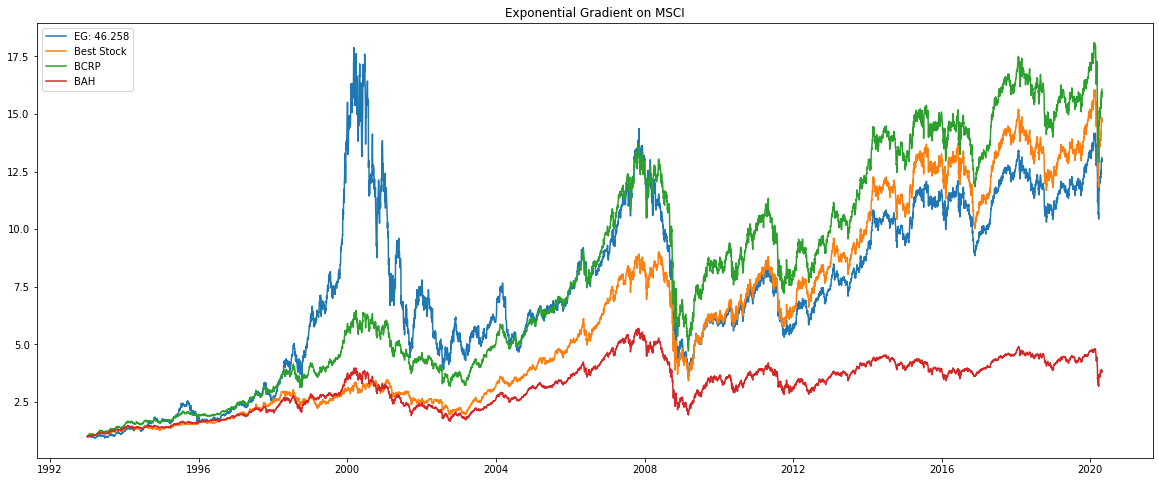

In [163]:
msci_bah = BuyAndHold(); msci_bah.allocate(msci)
msci_bcrp = BestConstantRebalancedPortfolio(); msci_bcrp.allocate(msci)
plt.plot(msci_large_eta_list[msci_large_eta_optuna.best_trial.number].portfolio_return, label = 'EG: 46.258')
plt.plot(msci_beststock.portfolio_return, label = 'Best Stock')
plt.plot(msci_bcrp.portfolio_return, label = 'BCRP')
plt.plot(msci_bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on MSCI')

## US Equity: 2011-2020

In [164]:
us_equity.tail()

,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-21,268.369995,94.050003,230.750000,2328.120117,81.519997,21.639999,275750.0,41.570000,109.849998,35.709999,...,118.887138,72.279999,71.839996,14.690000,29.870001,100.620003,32.730000,26.840000,129.210007,40.959999
2020-04-22,276.100006,95.480003,229.289993,2363.489990,82.540001,21.799999,279660.0,42.240002,110.639999,35.730000,...,118.609001,73.059998,74.680000,15.340000,29.469999,97.610001,33.250000,26.799999,131.589996,42.130001
2020-04-23,275.029999,93.940002,232.490005,2399.449951,82.459999,21.870001,278750.0,42.459999,112.910004,36.090000,...,119.400002,71.779999,73.809998,16.520000,29.500000,99.449997,33.369999,26.530001,128.529999,43.450001
2020-04-24,282.970001,94.059998,236.279999,2410.219971,83.169998,22.180000,279460.0,43.099998,114.040001,37.160000,...,118.779999,73.669998,76.040001,16.110001,29.709999,100.180000,34.000000,26.920000,129.440002,43.730000
2020-04-27,283.170013,94.949997,242.429993,2376.000000,85.059998,23.469999,281264.0,46.560001,115.199997,38.209999,...,117.449997,74.919998,75.980003,16.049999,30.540001,102.550003,35.880001,28.410000,128.300003,43.939999


In [166]:
us_equity_beststock = BestStock(); us_equity_beststock.allocate(us_equity)
display(us_equity_beststock.all_weights.iloc[-1].to_frame().T); display(us_equity.iloc[-1].to_frame().T)

,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
2020-04-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
2020-04-27,283.170013,94.949997,242.429993,2376.0,85.059998,23.469999,281264.0,46.560001,115.199997,38.209999,...,117.449997,74.919998,75.980003,16.049999,30.540001,102.550003,35.880001,28.41,128.300003,43.939999


In [167]:
data = 'equity'

with open('pickled/' + data + '/EG/small_eta_list.pickle', 'rb') as f:
    us_equity_small_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/small_eta_optuna.pickle', 'rb') as f:
    us_equity_small_eta_optuna = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_list.pickle', 'rb') as f:
    us_equity_large_eta_list = pickle.load(f)
with open('pickled/' + data + '/EG/large_eta_optuna.pickle', 'rb') as f:
    us_equity_large_eta_optuna = pickle.load(f)

In [168]:
# Eta of [0, 1] for US Equity
optuna.visualization.plot_slice(us_equity_small_eta_optuna)

In [169]:
# Eta of [1, 100] for US Equity
optuna.visualization.plot_slice(us_equity_large_eta_optuna)

In [170]:
display(us_equity_large_eta_optuna.best_params); display(us_equity_large_eta_optuna.best_trial)

{'eta': 22.67681684948512}

FrozenTrial(number=162, value=5.244109792255035, datetime_start=datetime.datetime(2020, 4, 28, 10, 51, 34, 100913), datetime_complete=datetime.datetime(2020, 4, 28, 10, 51, 34, 279152), params={'eta': 22.67681684948512}, distributions={'eta': UniformDistribution(high=100, low=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=162, state=TrialState.COMPLETE)

Text(0.5, 1.0, 'Exponential Gradient on US Equity')

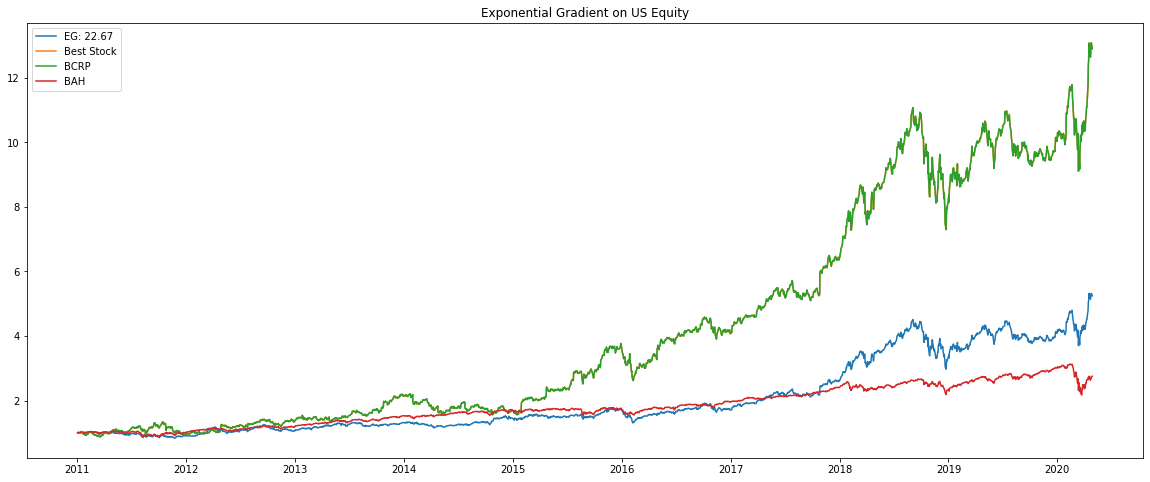

In [171]:
us_equity_bah = BuyAndHold(); us_equity_bah.allocate(us_equity)
us_equity_bcrp = BestConstantRebalancedPortfolio(); us_equity_bcrp.allocate(us_equity)
plt.plot(us_equity_large_eta_list[us_equity_large_eta_optuna.best_trial.number].portfolio_return, label = 'EG: 22.67')
plt.plot(us_equity_beststock.portfolio_return, label = 'Best Stock')
plt.plot(us_equity_bcrp.portfolio_return, label = 'BCRP')
plt.plot(us_equity_bah.portfolio_return, label = 'BAH'); plt.legend(); plt.title('Exponential Gradient on US Equity')

## Conclusion

Through this notebook, we were able to explore the basic functionalities of MlFinLab's newest Online Portfolio Selection module. Readers were exposed to a basic introduction to the exponential gradient strategy and will be able to replicate results using the simple methods of the new module.

The next notebook will focus on Momentum strategy called Follow the Leader.

If you enjoyed reading this please remember to leave us a star on GitHub and always let us know how to improve our modules!

:)